In [5]:
import os
import sys

# Get the absolute path of the current notebook's directory
notebook_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(notebook_dir, ".."))
sys.path.append(parent_dir)  # Add parent directory to sys.path

import pandas as pd
import torch
import math 
import numpy as np 
import matplotlib.pyplot as plt
from utils.utils_data import (load_data, train_valid_test_split, plot_example, plot_predictions, weighted_mean, r2_score)
# supress error log from font
import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)
import warnings
from numpy.exceptions import ComplexWarning

import e3nn.o3 as o3
from e3nn.util.jit import compile_mode
from e3nn.io import CartesianTensor
from e3nn.o3 import wigner_D, so3_generators

import seaborn as sns
# Suppress ComplexWarning
warnings.filterwarnings("ignore", category=ComplexWarning)

In [6]:
data_file = '../dataset/openmx_data_20250312_105926.pkl'
df, species = load_data(data_file)
df.sample(5)

,folder,formula,structure,mp_id,bandgap,crystal_system,omega,real_Permittivity_Matrices,imag_Permittivity_Matrices,Re_00,...,Im_02,Im_10,Im_11,Im_12,Im_20,Im_21,Im_22,avg_re_trace,avg_im_trace,species
247,/global/cfs/cdirs/m225/angush/materialProject/...,Cd4SeTe3,"(Atom('Cd', [0.0, 0.0, 6.28752439], index=0), ...",mp-1226783,0.5179,orthorhombic,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[[[3.628443266143422, 5.2575302222075435e-09, ...","[[[-2.9935408106768994e-18, -1.391355441889115...","[3.628443266143422, 3.628493772029995, 3.62864...",...,"[1.9507797979725342e-17, 1.883176648933331e-10...","[-1.3913554418891158e-18, 6.76613436010695e-12...","[2.5194248142692617e-17, 0.0004770940298302828...","[4.222731564312142e-18, -1.6023894304488607e-1...","[1.9507797979725342e-17, 1.883176648933331e-10...","[4.222731564312142e-18, -1.6023894304488607e-1...","[-2.055202003527174e-17, 0.0004820465433968365...","[3.6387087371748517, 3.6387573897802383, 3.638...","[5.495624322479925e-19, 0.0004890645510033988,...","[Cd, Te, Se]"
580,/global/cfs/cdirs/m225/angush/materialProject/...,Br24K8Pd4,"(Atom('K', [2.578275, 7.734825000000002, 7.734...",mp-1205761,0.5077,cubic,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[[[3.227923488151142, 3.3550835558332494e-09, ...","[[[-6.468734462519187e-16, -8.85845238901299e-...","[3.227923488151142, 3.2280115172374613, 3.2282...",...,"[3.9458186326290725e-19, 1.5285642524121899e-1...","[-8.85845238901299e-19, 3.076142426447063e-12,...","[-2.176489037833186e-16, 0.000885090466201642,...","[-3.969813850410225e-19, -1.3065689909550609e-...","[3.9458186326290725e-19, 1.5285642524121899e-1...","[-3.969813850410225e-19, -1.3065689909550609e-...","[-2.1529119026519219e-16, 0.000885090778656654...","[3.22792511187085, 3.2280131410054307, 3.22827...","[-3.5993784676680983e-16, 0.000885090379422911...","[Br, Pd, K]"
484,/global/cfs/cdirs/m225/angush/materialProject/...,K6S8Sb2,"(Atom('K', [0.0, 3.87795, 0.0], index=0), Atom...",mp-9911,2.1341,cubic,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[[[1.870501358317953, 4.6161256337719243e-10, ...","[[[9.478449623917044e-18, 1.5019243665998386e-...","[1.870501358317953, 1.8705086692708528, 1.8705...",...,"[4.377901500924583e-18, 1.6688719871234927e-11...","[1.5019243665998386e-18, 1.0686837835288638e-1...","[3.606707866254604e-18, 7.316241147714771e-05,...","[-4.249301463910295e-18, -1.4630141554703722e-...","[4.377901500924583e-18, 1.6688719871234927e-11...","[-4.249301463910295e-18, -1.4630141554703722e-...","[1.128043207068469e-17, 7.316199112015437e-05,...","[1.870501354882446, 1.8705086658353738, 1.8705...","[8.121863186952113e-18, 7.316220115917074e-05,...","[S, Sb, K]"
1476,/global/cfs/cdirs/m225/angush/materialProject/...,Hf4Mg4N8,"(Atom('Hf', [5.453564710877849, 5.453525, 1.14...",mp-1245813,0.8472,tetragonal,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[[[3.921247363050359, 6.996346322069557e-08, 0...","[[[-1.003471877825427e-17, -1.3530470885684747...","[3.921247363050359, 3.921268502104691, 3.92133...",...,"[-4.04255173207208e-20, 6.020174261194903e-08,...","[-1.3530470885684747e-18, 8.787929311257487e-1...","[-9.889933293391106e-18, 0.0002117450918116626...","[8.91894248367812e-18, -2.346210755144415e-12,...","[-4.04255173207208e-20, 6.020174261194903e-08,...","[8.91894248367812e-18, -2.346210755144415e-12,...","[6.711319523945135e-18, 0.00015989822449161842...","[3.851791029208865, 3.851810451813973, 3.85186...","[-4.404444182566747e-18, 0.0001944203882426828...","[Mg, N, Hf]"
407,/global/cfs/cdirs/m225/angush/materialProject/...,O4Tl8,"(Atom('Tl', [0.9897469509970911, 1.77325, 8.35...",mp-551470,0.5194,monoclinic,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[[[8.09633716488164, 2.1121750665161727e-07, 0...","[[[1.3695453055739105e-17, -2.5957252520568835...","[8.09633716488164, 8.096820172147433, 8.098269...",...,"[1.5071075484990763e-18, 6.401560700985647e-05...","[-2.5957252520568835e-18, 4.238476009545228e-1...","

# Re Permittivity real part to SH

re_permittivity shape: torch.Size([3001, 3, 3])


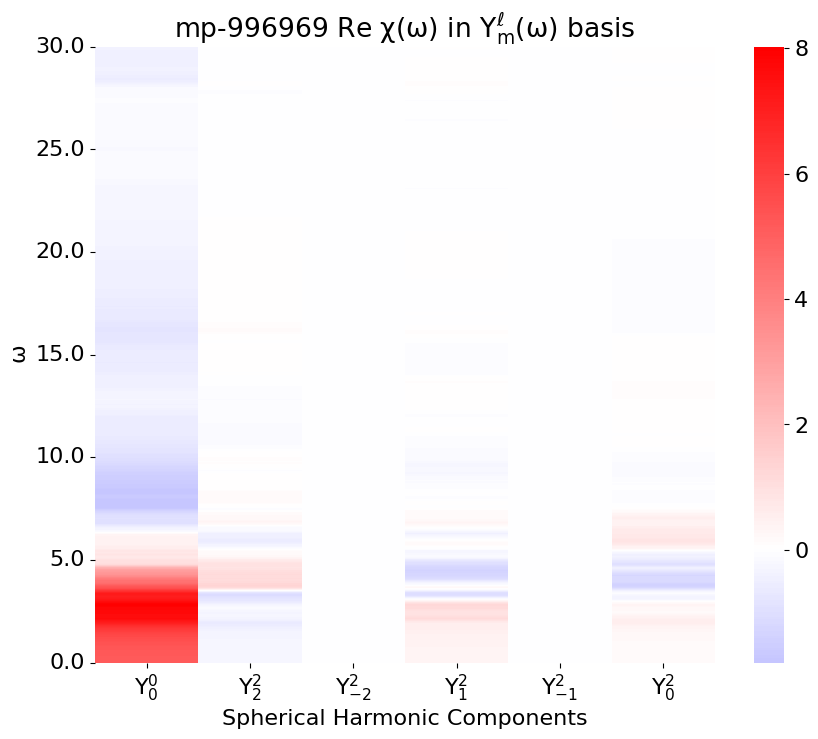

In [7]:
# Set default dtype globally
torch.set_default_dtype(torch.float64)

N_samples = 1
# sampled_df = df.sample(n=N_samples)  # Fix seed for reproducibility
selected_df = df[df["mp_id"] == "mp-996969"] # monoclinic
# selected_df = df[df["mp_id"] == "mp-766"] # orthorhombic
# selected_df = df[df["mp_id"] == "mp-29678"] # trigonal
# selected_df = df[df["mp_id"] == "mp-441"] # cubic
# selected_df = df[df["mp_id"] == "mp-8311"] # tetragonal
# selected_df = df[df["mp_id"] == "mp-1039"] # hexagonal
# selected_df = df[df["mp_id"] == "mp-2051619"] # triclinic


# Define irreps (L=0, L=2 components)
irreps_out = o3.Irreps("251x0e + 251x2e")  # 3001 x L=0 (1) + 3001 x L=2 (5)

# Load real part of permittivity tensor
re_permittivity = torch.tensor(selected_df["real_Permittivity_Matrices"].iloc[0], dtype=torch.float64)  # Use float64 directly
omega = selected_df["omega"].iloc[0]
print("re_permittivity shape:", re_permittivity.shape)

omega_max = max(omega)
sample_ticks = np.arange(0, omega_max + 1, 5)  # Ensure it reaches max(omega)

# Find the closest indices in the data corresponding to these ticks
sample_indices = np.searchsorted(omega, sample_ticks)

# Define component labels
component_ticks = [r"$Y^0_0$", r"$Y^2_2$", r"$Y^2_{-2}$", r"$Y^2_1$", r"$Y^2_{-1}$", r"$Y^2_0$"]

# Transform Cartesian tensor
x = CartesianTensor("ij=ji")  # Symmetric rank-2 tensor
X_irrep = x.from_cartesian(re_permittivity)  # Converts (N, 3, 3) -> (N, 6)

# Create the heatmap plot
plt.figure(figsize=(10, 8))
ax = sns.heatmap(X_irrep.numpy(), cmap='bwr', center=0, xticklabels=component_ticks)

# Update y-axis to use correctly spaced tick positions
ax.set_yticks(sample_indices)
ax.set_yticklabels(sample_ticks)

# Flip y-axis so omega increases from bottom to top
ax.invert_yaxis()

# Labels and title
plt.title(rf"{selected_df.mp_id.iloc[0]} Re $\chi(\omega)$ in $Y^{{\ell}}_{{m}}(\omega)$ basis")
plt.xlabel("Spherical Harmonic Components")
plt.ylabel(r"$\omega$")

plt.show()